## Data Noramlization (mean and variance) for Cifar10 : PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import random
import numpy as np
import matplotlib.pyplot as plt

## Step 0. Device Stepup

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cpu


Hyperparameters

In [3]:
learning_rate = 1e-3
batch_size = 100
epochs = 20

### Step 1. Data -  target class : 10

### mean and variance normalization for Cifar10

In [4]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # mean & var normalization for each channel
])

In [5]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
test_data : Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


### Step 2. Deep NN Model (5-layers)

In [7]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

model = NN().to(device)

### Step 3. Loss and Optimizer

In [8]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 4. & 5. Train/Test the model

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    correct /= size
    print(f"Train - Avg loss: {train_loss:>8f},  Accuracy: {(100*correct):>0.1f}%", end = "  ")

    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test - Avg loss: {test_loss:>8f}  Accuracy: {(100*correct):>0.1f}%")

    return test_loss, correct

In [10]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)

    loss_t, acc_t = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss_t)
    test_acc.append(acc_t)

print("Done!")

Epoch 1 :  Train - Avg loss: 1.688895,  Accuracy: 40.0%  Test - Avg loss: 1.522238  Accuracy: 46.1%
Epoch 2 :  Train - Avg loss: 1.462889,  Accuracy: 48.2%  Test - Avg loss: 1.447926  Accuracy: 49.3%
Epoch 3 :  Train - Avg loss: 1.334506,  Accuracy: 53.0%  Test - Avg loss: 1.410924  Accuracy: 51.4%
Epoch 4 :  Train - Avg loss: 1.227901,  Accuracy: 56.4%  Test - Avg loss: 1.407930  Accuracy: 51.6%
Epoch 5 :  Train - Avg loss: 1.132651,  Accuracy: 59.7%  Test - Avg loss: 1.487097  Accuracy: 51.1%
Epoch 6 :  Train - Avg loss: 1.050232,  Accuracy: 62.3%  Test - Avg loss: 1.508022  Accuracy: 52.0%
Epoch 7 :  Train - Avg loss: 0.978128,  Accuracy: 64.6%  Test - Avg loss: 1.593593  Accuracy: 51.0%
Epoch 8 :  Train - Avg loss: 0.910665,  Accuracy: 67.0%  Test - Avg loss: 1.670627  Accuracy: 51.9%
Epoch 9 :  Train - Avg loss: 0.851070,  Accuracy: 69.1%  Test - Avg loss: 1.753840  Accuracy: 50.6%
Epoch 10 :  Train - Avg loss: 0.800993,  Accuracy: 70.9%  Test - Avg loss: 1.906519  Accuracy: 51.2%

### Plot the Training/Test Loss

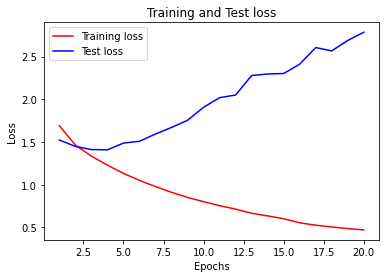

In [11]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot the Training/Test Accuracy

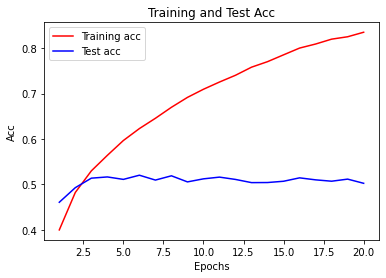

In [12]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()